<span style="color:darkolivegreen;font-weight:800;font-size:32px">
    Building Agentic Apps: ArangoDB, NVIDIA cuGraph, and NetworkX Hackathon
</span>

<br>

<p align="center">
    <img src="https://arangodb.com/wp-content/uploads/2016/05/ArangoDB_logo_avocado_@1.png" style="height: 50px;">
    <img src="https://www.nvidia.com/content/dam/en-zz/Solutions/about-nvidia/logo-and-brand/02-nvidia-logo-color-grn-500x200-4c25-p@2x.png" style="height: 50px;">
    <img src="https://rapids.ai/images/RAPIDS-logo.png" style="height: 50px;">
    <img src="https://avatars.githubusercontent.com/u/388785?s=200&v=4" style="height: 50px;">
</p>

### **Step 0**: Package Installation and Setup

In [1]:
# 1. Install all requirements via pip

# !pip install -r requirements.txt

In [2]:
# 2. Check if you have an NVIDIA GPU
# Note: If this returns "command not found", then GPU-based algorithms via cuGraph are unavailable

# !nvidia-smi
# !nvcc --version

In [3]:
# 3. Install nx-cugraph via pip, requires CUDA-capable GPU
# Note: Only enable this installation if the step above is working!

# !pip install nx-cugraph-cu12 --extra-index-url https://pypi.nvidia.com

In [4]:
# 4. Import the required modules

import os
import re
import json
import pandas as pd
import networkx as nx
from typing import Dict
from typing import List
import nx_arangodb as nxadb
import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import islice
from dotenv import load_dotenv
from arango import ArangoClient

from adbnx_adapter.typings import NxId
from adbnx_adapter.typings import NxData
from adbnx_adapter import ADBNX_Adapter
from adbnx_adapter import ADBNX_Controller

load_dotenv(".env")

[00:40:09 +0700] [INFO]: NetworkX-cuGraph is unavailable: No module named 'cupy'.


True

### **Step 1**: Prepare and Load Dataset for `NetworkX`

In [5]:
def list_of_dict_to_json(data: list[dict], output_path: str) -> None:
    if not output_path.endswith(".json"):
        output_path = f"{output_path}.json"

    with open(output_path, "w", encoding="utf-8") as output_file:
        json.dump(data, output_file, indent=4)


def load_dataset_from_dir(dir_path: str) -> dict[str, pd.DataFrame]:
    json_data = {}
    json_files = sorted([file for file in os.listdir(dir_path) if file.endswith(".json")], reverse=True)
    
    for json_file in json_files:
        with open(os.path.join(dir_path, json_file), "r", encoding="utf-8") as file:
            json_data[os.path.splitext(json_file)[0]] = json.load(file)
    
    return json_data


def prepare_regulation_data(regulation_data: list[dict], output_dir: str, verbose: bool = True) -> None:
    result = {
    # Node
        "node_Regulation": [],
        "node_Consideration": [],
        "node_Observation": [],
        "node_Article": [],
        "node_Definition": [],
    # Relationship
        "edge_reg_AMENDED_BY": [],
        "edge_HAS_CONSIDERATION": [],
        "edge_HAS_OBSERVATION": [],
        "edge_HAS_DEFINITION": [],
        "edge_HAS_ARTICLE": [],
        "edge_NEXT_ARTICLE": [],
        "edge_REFER_TO": [],
        "edge_art_AMENDED_BY": [],
    }

    edge_NEXT_ARTICLE_1 = []
    edge_NEXT_ARTICLE_2 = []

    for regulation in tqdm(iterable=regulation_data, desc="Transform regulation data", disable=not verbose):
        result["node_Regulation"].append({
            "id": int(regulation["id"]),
            "title": regulation["title"],
            "about": regulation["about"],
            "type": regulation["short_type"],
            "number": int(regulation["number"]),
            "year": int(regulation["year"]),
            "is_amendment": bool(int(regulation["amendment"])),
            "amendment_order": int(regulation["amendment"]),
            "institution": regulation["institution"],
            "issue_place": regulation["issue_place"],
            "issue_date": regulation["issue_date"] if regulation["issue_date"] else None,
            "effective_date": regulation["effective_date"] if regulation["effective_date"] else None,
            "subjects": regulation["subjects"],
            "reference_url": regulation["url"],
            "download_url": regulation["download_link"],
            "download_name": regulation["download_name"]
        })

        for amended_regulation in regulation["status"]["amend"]:
            if re.search(r"peraturan\.bpk\.go\.id", amended_regulation, re.IGNORECASE) is None:
                result["edge_reg_AMENDED_BY"].append({
                    "from_type": "Regulation",
                    "from": int(regulation["id"]),
                    "to_type": "Regulation",
                    "to": int(amended_regulation)
                })

        for key, content in regulation["content"].items():
            if key == "considering":
                result["node_Consideration"].append({
                    "id": int(content["id"]),
                    "text": content["text"]
                })

                result["edge_HAS_CONSIDERATION"].append({
                    "from_type": "Regulation",
                    "from": int(regulation["id"]),
                    "to_type": "Consideration",
                    "to": int(content["id"])
                })

            elif key == "observing":
                result["node_Observation"].append({
                    "id": int(content["id"]),
                    "text": content["text"]
                })

                result["edge_HAS_OBSERVATION"].append({
                    "from_type": "Regulation",
                    "from": int(regulation["id"]),
                    "to_type": "Observation",
                    "to": int(content["id"])
                })

            elif key == "articles":
                for article in content.values():
                    text = (
                        f"{regulation['title']}, "
                        f"{(article['chapter_about'] or '') + ', ' if article['chapter_about'] else ''}"
                        f"{(article['part_about'] or '') + ', ' if article['part_about'] else ''}"
                        f"{(article['paragraph_about'] or '') + ', ' if article['paragraph_about'] else ''}"
                        f"Pasal {article['article_number']}:\n"
                        f"{article['text']}".strip()
                    )

                    result["node_Article"].append({
                        "id": int(article["id"]),
                        "number": article["article_number"],
                        "chapter": article["chapter_number"] if article["chapter_number"] else None,
                        "part": article["part_number"] if article["part_number"] else None,
                        "paragraph": article["paragraph_number"] if article["paragraph_number"] else None,
                        "text": text
                    })

                    result["edge_HAS_ARTICLE"].append({
                        "from_type": "Regulation",
                        "from": int(regulation["id"]),
                        "to_type": "Article",
                        "to": int(article["id"])
                    })

                    if article["previous_article"]:
                        edge_NEXT_ARTICLE_1.append((
                            int(article["previous_article"]),
                            int(article["id"]),
                            int(regulation["amendment"])
                        ))

                    if article["next_article"]:
                        edge_NEXT_ARTICLE_2.append((
                            int(article["id"]),
                            int(article["next_article"]),
                            int(regulation["amendment"])
                        ))

                    if article["references"]:
                        for reference_article_id in article["references"]:
                            result["edge_REFER_TO"].append({
                                "from_type": "Article",
                                "from": int(article["id"]),
                                "to_type": "Article",
                                "to": int(reference_article_id)
                            })

                    if article["amend"]:
                        for amended_article_id in article["amend"]:
                            result["edge_art_AMENDED_BY"].append({
                                "from_type": "Article",
                                "from": int(article["id"]),
                                "to_type": "Article",
                                "to": int(amended_article_id)
                            })

            else:
                for definition in content:
                    text = (
                        f"{regulation['title']}, "
                        f"Definisi {definition['name']}:\n"
                        f"{definition['definition']}".strip()
                    )

                    result["node_Definition"].append({
                        "id": int(definition["id"]),
                        "name": definition["name"],
                        "text": text,
                    })

                    result["edge_HAS_DEFINITION"].append({
                        "from_type": "Regulation",
                        "from": int(regulation["id"]),
                        "to_type": "Definition",
                        "to": int(definition["id"])
                    })

    for edge in sorted(set(edge_NEXT_ARTICLE_1 + edge_NEXT_ARTICLE_2)):
        result["edge_NEXT_ARTICLE"].append({
            "from_type": "Article",
            "from": edge[0],
            "to_type": "Article",
            "to": edge[1],
            "amendment_order": edge[2]
        })

    for key, value in tqdm(iterable=result.items(), desc="Save transformed data to JSON", disable=not verbose):
        list_of_dict_to_json(data=value, output_path=os.path.join(output_dir, f"{key}.json"))

In [6]:
# 1. Prepare dataset from initial JSON file

json_raw_input = os.path.join("data", "raw", "raw.json")
with open(json_raw_input) as file:
    json_data = json.load(file)

prepare_regulation_data(
    regulation_data=json_data,
    output_dir="data",
    verbose=True
)

Save transformed data to JSON: 100%|██████████| 13/13 [00:00<00:00, 48.08it/s]


In [7]:
# 2. Load dataset from prepared JSON file

dataset = load_dataset_from_dir("data")

print(f"{'Dataset':<25}: {len(dataset):>5}  Entity")
for index, data in enumerate(dataset.items()):
    key, value = data
    print_value = f"{key:<25}: {len(value):>5}  data {type(value)} of {type(value[0])}"
    if index == 0: print("-" * len(print_value))
    print(print_value)

Dataset                  :    13  Entity
-----------------------------------------------------------------------
node_Regulation          :    63  data <class 'list'> of <class 'dict'>
node_Observation         :    63  data <class 'list'> of <class 'dict'>
node_Definition          :   957  data <class 'list'> of <class 'dict'>
node_Consideration       :    63  data <class 'list'> of <class 'dict'>
node_Article             :  2423  data <class 'list'> of <class 'dict'>
edge_reg_AMENDED_BY      :    26  data <class 'list'> of <class 'dict'>
edge_art_AMENDED_BY      :    83  data <class 'list'> of <class 'dict'>
edge_REFER_TO            :  1497  data <class 'list'> of <class 'dict'>
edge_NEXT_ARTICLE        :  2422  data <class 'list'> of <class 'dict'>
edge_HAS_OBSERVATION     :    63  data <class 'list'> of <class 'dict'>
edge_HAS_DEFINITION      :   957  data <class 'list'> of <class 'dict'>
edge_HAS_CONSIDERATION   :    63  data <class 'list'> of <class 'dict'>
edge_HAS_ARTICLE       

### **Step 2**: Convert and Load Graph Data into `NetworkX`

In [8]:
# 1. Crate empty multi directed graph

G = nx.MultiDiGraph()

In [9]:
# 2. Load node data into multi directed graph

for key, data in dataset.items():
    if key.startswith("node_"):
        label = re.search(r"node_(.*)", key, re.IGNORECASE)[1].lower()
        for row in data:
            node_id = f"{label}/{row['id']}"
            attributes = dict(islice(row.items(), 1, None))
            G.add_node(node_id, **attributes)

print(f"Total node: {G.number_of_nodes()}")

Total node: 3569


In [10]:
# 3. Load edge data into multi directed graph

for key, data in dataset.items():
    if key.startswith("edge_"):
        edge_type = re.search(r"([A-Z_]*)$", key)[1]
        edge_type = edge_type[1:].lower()
        for row in data:
            source_id = f"{row['from_type'].lower()}/{row['from']}"
            target_id = f"{row['to_type'].lower()}/{row['to']}"
            attributes = dict(islice(row.items(), 4, None))
            G.add_edge(source_id, target_id, type=edge_type, **attributes)

print(f"Total edge: {G.number_of_edges()}")

Total edge: 7534


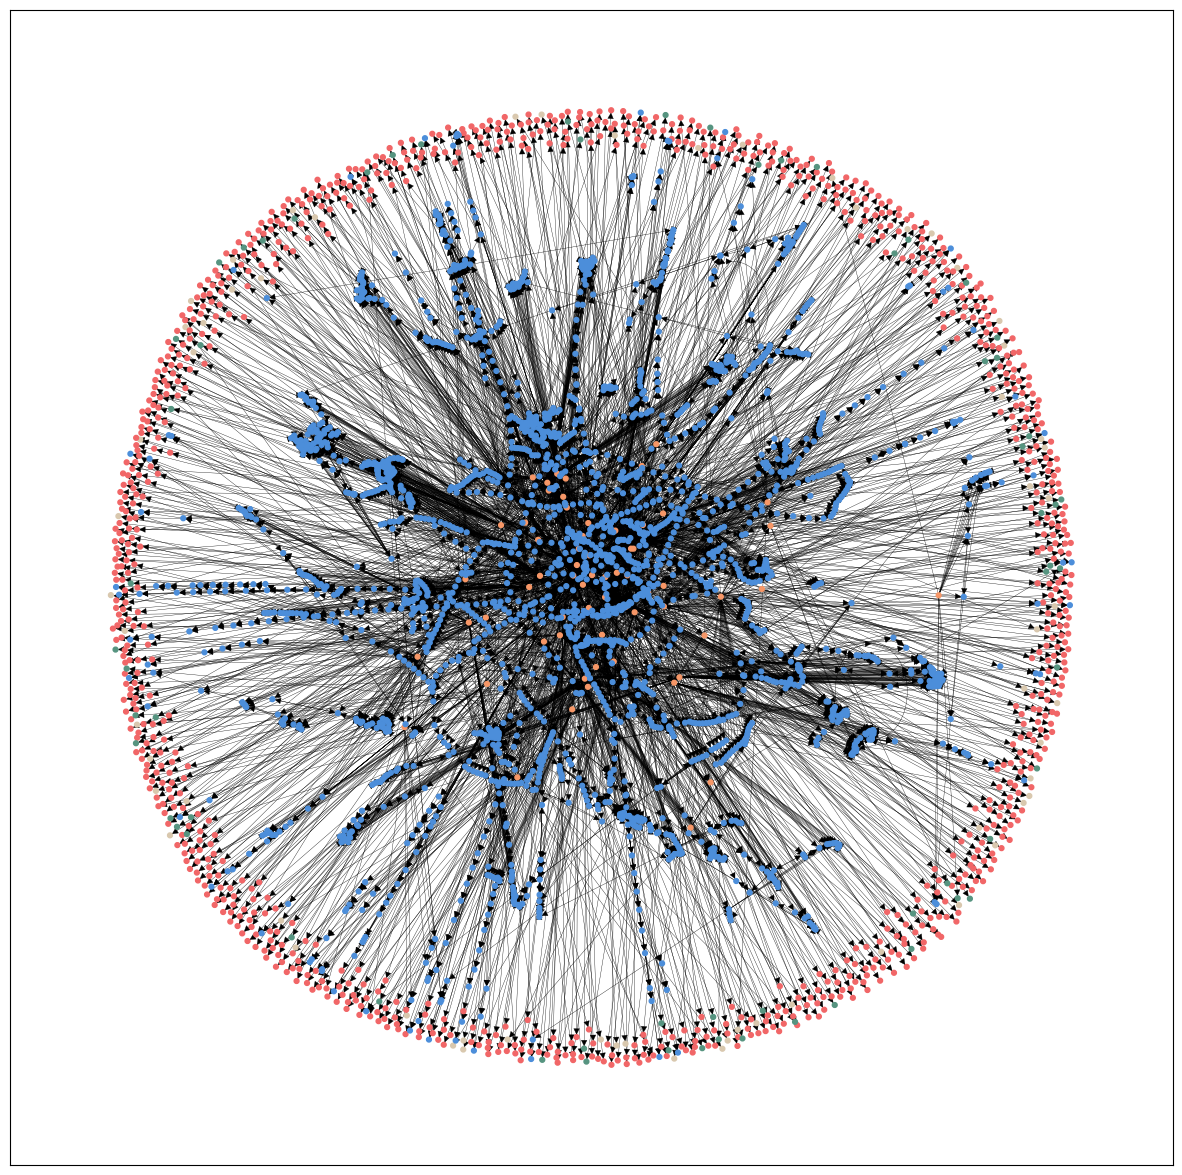

In [11]:
# 3. Visualize the Graph
# Reference: https://networkx.org/nx-guides/content/exploratory_notebooks/facebook_notebook.html#visualizing-the-graph

label_colors = {
    "regulation": "#f79767",     # Orange
    "consideration": "#569480",  # Green
    "observation": "#d9c8ae",    # Cream
    "definition": "#f16667",     # Red
    "article": "#4c8eda"         # Blue
}

colors = []
for node, data in G.nodes(data=True):
    collection = re.search(r"^(.*)/\d+$", node)[1]
    color = label_colors[collection]
    colors.append(color)

plot_options = {"node_size": 12, "with_labels": False, "width": 0.25, "node_color": colors}
pos = nx.spring_layout(G, iterations=100, seed=42)
fig, ax = plt.subplots(figsize=(15, 15))
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

### **Step 3**: Persist the Graph in ArangoDB

In [12]:
# 1. Connect to the ArangoDB database

db = ArangoClient(hosts=os.environ["DATABASE_HOST"]).db(
    name=os.environ["DATABASE_NAME"],
    username=os.environ["DATABASE_USERNAME"],
    password=os.environ["DATABASE_PASSWORD"],
    verify=True
)

print(db)

<StandardDatabase hackathon>


In [13]:
# 2. Create edge definitions and custom ADBNX controller

# Specify list of ArangoDB edge definitions
edge_definitions = [
    {
        "edge_collection": "amended_by",
        "from_vertex_collections": ["regulation", "article"],
        "to_vertex_collections": ["regulation", "article"],
    },
    {
        "edge_collection": "has_consideration",
        "from_vertex_collections": ["regulation"],
        "to_vertex_collections": ["consideration"],
    },
    {
        "edge_collection": "has_observation",
        "from_vertex_collections": ["regulation"],
        "to_vertex_collections": ["observation"],
    },
    {
        "edge_collection": "has_definition",
        "from_vertex_collections": ["regulation"],
        "to_vertex_collections": ["definition"],
    },
    {
        "edge_collection": "has_article",
        "from_vertex_collections": ["regulation"],
        "to_vertex_collections": ["article"],
    },
    {
        "edge_collection": "next_article",
        "from_vertex_collections": ["article"],
        "to_vertex_collections": ["article"],
    },
    {
        "edge_collection": "refer_to",
        "from_vertex_collections": ["article"],
        "to_vertex_collections": ["article"],
    }
]

# Create custom ADBNX Controller to handle node and edge transition from NetworkX to ArangoDB
# Reference: https://github.com/arangoml/networkx-adapter/blob/master/examples/outputs/ArangoDB_NetworkX_Adapter_output.ipynb
class Custom_ADBNX_Controller(ADBNX_Controller):
    """ArangoDB-NetworkX controller.

    Responsible for controlling how nodes & edges are handled when
    transitioning from ArangoDB to NetworkX, and vice-versa.
    """

    def _identify_networkx_node(
        self, nx_node_id: NxId, nx_node: NxData, adb_v_cols: List[str]
    ) -> str:
        """Given a NetworkX node, and a list of ArangoDB vertex collections defined,
        identify which ArangoDB vertex collection **nx_node** should belong to.

        NOTE: You must override this function if len(**adb_v_cols**) > 1.

        :param nx_node_id: The NetworkX ID of the node.
        :type nx_node_id: adbnx_adapter.typings.NxId
        :param nx_node: The NetworkX node object.
        :type nx_node: adbnx_adapter.typings.NxData
        :param adb_v_cols: All ArangoDB vertex collections specified
            by the **edge_definitions** parameter of networkx_to_arangodb()
        :type adb_v_cols: List[str]
        :return: The ArangoDB collection name
        :rtype: str
        """
        return str(nx_node_id).split("/")[0]  # Identify node based on '/' split


    def _identify_networkx_edge(
        self,
        nx_edge: NxData,
        from_node_id: NxId,
        to_node_id: NxId,
        nx_map: Dict[NxId, str],
        adb_e_cols: List[str],
    ) -> str:
        """Given a NetworkX edge, its pair of nodes, and a list of ArangoDB
        edge collections defined, identify which ArangoDB edge collection **nx_edge**
        should belong to.

        NOTE #1: You must override this function if len(**adb_e_cols**) > 1.

        :param nx_edge: The NetworkX edge object.
        :type nx_edge: adbnx_adapter.typings.NxData
        :param from_node_id: The NetworkX ID of the node representing the edge source.
        :type from_node_id: adbnx_adapter.typings.NxId
        :param to_node_id: The NetworkX ID of the node representing the edge destination.
        :type to_node_id: adbnx_adapter.typings.NxId
        :param nx_map: A mapping of NetworkX node ids to ArangoDB vertex ids. You
            can use this to derive the ArangoDB _from and _to values of the edge.
            i.e, `nx_map[from_node_id]` will give you the ArangoDB _from value,
            and `nx_map[to_node_id]` will give you the ArangoDB _to value.
        :type nx_map: Dict[NxId, str]
        :param adb_e_cols: All ArangoDB edge collections specified
            by the **edge_definitions** parameter of
            ADBNX_Adapter.networkx_to_arangodb()
        :type adb_e_cols: List[str]
        :return: The ArangoDB collection name
        :rtype: str
        """
        return nx_edge["type"]  # Identify edge based on "type" attribute
    

    def _keyify_networkx_node(
        self, i: int, nx_node_id: NxId, nx_node: NxData, col: str
    ) -> str:
        """Given a NetworkX node, derive its ArangoDB key.

        NOTE #1: You must override this function if you want to create custom ArangoDB
        _key values for your NetworkX nodes.

        NOTE #2: You are free to use `_string_to_arangodb_key_helper()` and
        `_tuple_to_arangodb_key_helper()` to derive a valid ArangoDB _key value.

        :param i: The index of the NetworkX node in the list of nodes.
        :type i: int
        :param nx_node_id: The NetworkX node id.
        :type nx_node_id: adbnx_adapter.typings.NxId
        :param nx_node: The NetworkX node object.
        :type nx_node: adbnx_adapter.typings.NxData
        :param col: The ArangoDB collection that **nx_node** belongs to.
        :type col: str
        :return: A valid ArangoDB _key value.
        :rtype: str
        """
        return str(nx_node_id).split("/")[1] # Keyify node based on '/' split

In [14]:
# 3. Instantiate the custom ADBNX using the DB and custom ADBNX controller

custom_adbnx_adapter = ADBNX_Adapter(db, Custom_ADBNX_Controller())

[2025/03/07 00:44:38 +0700] [27840] [INFO] - adbnx_adapter: Instantiated ADBNX_Adapter with database 'hackathon'


In [15]:
# 4. Load the NetworkX Graph into new ArangoDB graph

name = "Hackathon"
db.delete_graph(name, drop_collections=True, ignore_missing=True)
G_adb = custom_adbnx_adapter.networkx_to_arangodb(name, G, edge_definitions, batch_size=128)
print(G_adb)

d:\Kuliah Semester 8\graph-rag-arangodb\.venv\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets"
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[2025/03/07 00:44:40 +0700] [27840] [INFO] - adbnx_adapter: Created ArangoDB 'Hackathon' Graph


<Graph Hackathon>


In [16]:
# 5. Re-connect to the same Graph

name = "Hackathon"
G_adb = nxadb.MultiDiGraph(name=name, db=db)
print(G_adb)

[00:44:40 +0700] [INFO]: Graph 'Hackathon' exists.
[00:44:40 +0700] [INFO]: Default node type set to 'article'


MultiDiGraph named 'Hackathon' with 3569 nodes and 7534 edges


In [ ]:
# 6. Test: Print the degree of a Node

G_adb.degree("regulation/201005029100000")

23

In [ ]:
# 7. Test: Query the Graph
# Reference: https://arangodb.com/sql-aql-comparison/

# Sample 3 nodes
result = G_adb.query("""
    FOR node IN regulation
        SORT RAND()
        LIMIT 3
        RETURN node
""")

display(list(result))
print("-"*10)

# Sample 3 edges
result = G_adb.query("""
    FOR edge IN amended_by
        SORT RAND()
        LIMIT 3
        RETURN edge
""")

display(list(result))
print("-"*10)

# Traverse a node's 1-hop neighborhood
result = G_adb.query("""
    FOR node, edge, path IN 1..1 ANY 'article/200705038601000' GRAPH Hackathon
        LIMIT 1
        RETURN path
""")

display(list(result))

[{'_key': '202105005100000',
  '_id': 'regulation/202105005100000',
  '_rev': '_jUwNKfC--I',
  'title': 'Peraturan Menteri Komunikasi dan Informatika Nomor 5 Tahun 2021 tentang Penyelenggaraan Telekomunikasi',
  'about': 'Penyelenggaraan Telekomunikasi',
  'type': 'PERMENKOMINFO',
  'number': 5,
  'year': 2021,
  'is_amendment': False,
  'amendment_order': 0,
  'institution': 'Kementerian Komunikasi dan Informatika',
  'issue_place': 'Jakarta',
  'issue_date': '2021-03-31',
  'effective_date': '2021-04-01',
  'subjects': ['TELEKOMUNIKASI, INFORMATIKA, SIBER, DAN INTERNET',
   'CIPTA KERJA'],
  'reference_url': 'https://peraturan.bpk.go.id/Details/203070/permenkominfo-no-5-tahun-2021',
  'download_url': 'https://peraturan.bpk.go.id/Download/197038/Nomor%205%20Tahun%202021_compressed.pdf',
  'download_name': 'PERMENKOMINFO_2021_005'},
 {'_key': '201505035100000',
  '_id': 'regulation/201505035100000',
  '_rev': '_jUwNKf---L',
  'title': 'Peraturan Menteri Komunikasi dan Informatika Nomor

----------


[{'_key': '1506',
  '_id': 'amended_by/1506',
  '_from': 'regulation/202105001100000',
  '_to': 'regulation/201905013100000',
  '_rev': '_jUwNLG2--A',
  'type': 'amended_by'},
 {'_key': '5063',
  '_id': 'amended_by/5063',
  '_from': 'article/202105001603500',
  '_to': 'article/201905013603500',
  '_rev': '_jUwNLva--L',
  'type': 'amended_by'},
 {'_key': '7329',
  '_id': 'amended_by/7329',
  '_from': 'article/201601019603100',
  '_to': 'article/200801011603100',
  '_rev': '_jUwNMCG--A',
  'type': 'amended_by'}]

----------


[{'vertices': [{'_key': '200705038601000',
    '_id': 'article/200705038601000',
    '_rev': '_jUwNKmO--l',
    'number': '10',
    'chapter': '4',
    'part': None,
    'paragraph': None,
    'text': 'Peraturan Menteri Komunikasi dan Informatika Nomor 38/PER/M.KOMINFO/9/2007 Tahun 2007 tentang Perubahan atas Peraturan Menteri Komunikasi dan Informatika Nomor 11/PER/M.KOMINFO/04/2007 tentang Penyediaan Kewajiban Pelayanan Universal Telekomunikasi, BAB IV - SELEKSI PELAKSANA PENYEDIAAN KPU TELEKOMUNIKASI, Pasal 10:\n(1) Pemenang seleksi pelaksana penyedia yang belum memillki izin penyelenggaraan jaringan tetap lokal diberikan izin penyelenggaraan jaringan tetap lokal dengan wilayah cakupan blok WPUT yang dimenangkan.\n(2) Dalam hal dimohon oleh pemenang seleksi, pemenang seleksi pelaksana penyedia yang belum memiliki izin penyelenggaraan jaringan tatap sambungan langsung jarak jauh diberikan izin penyelenggaraan jasa internet teleponi untuk keperluan publik dengan wilayah cakupan blok W

In [19]:
# 8. Test: Test node/edge calling

print("# NODE")
print(G_adb.nodes["regulation/200705011100000"])     # regulation node
print(G_adb.nodes["consideration/200705011200000"])  # consideration node
print(G_adb.nodes["observation/200705011300000"])    # observation node
print(G_adb.nodes["definition/201605004400200"])     # definition node
print(G_adb.nodes["article/200705011600200"])        # article node
print("----")

print("# EDGE")
print(G_adb["regulation/200705038100000"]["regulation/200705011100000"])     # amended_by (regulation) edge
print(G_adb["regulation/200705011100000"]["consideration/200705011200000"])  # has_consideration edge
print(G_adb["regulation/200705011100000"]["observation/200705011300000"])    # has_observation edge
print(G_adb["regulation/201605004100000"]["definition/201605004400200"])     # has_definition edge
print(G_adb["regulation/200705011100000"]["article/200705011600100"])        # has_article edge
print(G_adb["article/199901036600100"]["article/199901036600200"])           # next_article edge
print(G_adb["article/200705011601600"]["article/200705011600300"])           # refer_to edge
print(G_adb["article/200705038601000"]["article/200705011601000"])           # amended_by (article) edge

# NODE
{'_key': '200705011100000', '_id': 'regulation/200705011100000', 'title': 'Peraturan Menteri Komunikasi dan Informatika Nomor 11/PER/M.KOMINFO/4/2007 Tahun 2007 tentang Penyediaan Kewajiban Pelayanan Universal Telekomunikasi', 'about': 'Penyediaan Kewajiban Pelayanan Universal Telekomunikasi', 'type': 'PERMENKOMINFO', 'number': 11, 'year': 2007, 'is_amendment': False, 'amendment_order': 0, 'institution': 'Kementerian Komunikasi dan Informatika', 'issue_place': 'Jakarta', 'issue_date': '2007-04-13', 'effective_date': '2007-04-13', 'subjects': ['TELEKOMUNIKASI, INFORMATIKA, SIBER, DAN INTERNET', 'PERIZINAN, PELAYANAN PUBLIK'], 'reference_url': 'https://peraturan.bpk.go.id/Details/159911/permenkominfo-no-11permkominfo42007-tahun-200', 'download_url': 'https://peraturan.bpk.go.id/Download/152473/Permen%20Kominfo%20Nomor%2011%20Tahun%202007.pdf', 'download_name': 'PERMENKOMINFO_2007_011'}
{'_key': '200705011200000', '_id': 'consideration/200705011200000', 'text': 'a. bahwa telekomuni